In [1]:

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [3]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [4]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
#os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HUGGINGFACE_RW_TOKEN'] = os.getenv('HUGGINGFACE_RW_TOKEN', 'your-key-if-not-using-env')

In [6]:
# Log in to HuggingFace

hf_token = os.environ['HUGGINGFACE_RW_TOKEN']
login(hf_token, add_to_git_credential=True)

In [7]:
openai = OpenAI()

In [8]:
%matplotlib inline

In [9]:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [10]:

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [11]:

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [12]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'},
 {'role': 'assistant', 'content': 'Price is $226.95'}]

In [13]:

def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [14]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. 

In [15]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [16]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [17]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [18]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
train_file

FileObject(id='file-7YSWYiD3HbEfs42KHpB9d7', bytes=188742, created_at=1746729358, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [20]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [21]:
validation_file

FileObject(id='file-2Kamoc8uAEPAiQUBhHMzb8', bytes=47085, created_at=1746729426, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [23]:
#weight & bias
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [24]:
train_file.id

'file-7YSWYiD3HbEfs42KHpB9d7'

In [25]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-3LjmIGaTxaGvS184PCCL7aO1', created_at=1746730344, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-Z6HOoox3PV5ALK2KmpNysrXm', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-7YSWYiD3HbEfs42KHpB9d7', validation_file='file-2Kamoc8uAEPAiQUBhHMzb8', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-3LjmIGaTxaGvS184PCCL7aO1'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', usage_metr

In [26]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-3LjmIGaTxaGvS184PCCL7aO1', created_at=1746730344, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-Z6HOoox3PV5ALK2KmpNysrXm', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-7YSWYiD3HbEfs42KHpB9d7', validation_file='file-2Kamoc8uAEPAiQUBhHMzb8', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-3LjmIGaTxaGvS184PCCL7aO1'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer',

In [27]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [28]:
job_id

'ftjob-3LjmIGaTxaGvS184PCCL7aO1'

In [29]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-3LjmIGaTxaGvS184PCCL7aO1', created_at=1746730344, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-Z6HOoox3PV5ALK2KmpNysrXm', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-7YSWYiD3HbEfs42KHpB9d7', validation_file='file-2Kamoc8uAEPAiQUBhHMzb8', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-3LjmIGaTxaGvS184PCCL7aO1'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer', usage_metrics=None, shared_with_ope

In [31]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-26HB520mi3YvwvQmSmXW7l53', created_at=1746730907, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-0l0ZzHv5cfOpmV0Q6svFymiw', created_at=1746730901, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-UGulT3kfXTkMV7nWRiEflL12', created_at=1746730852, level='info', message='Step 200/200: training loss=1.14, validation loss=1.12, full validation loss=1.12', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 1.1364264488220215, 'valid_loss': 1.1192123889923096, 'total_steps': 200, 'full_valid_loss': 1.1200066089630127, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.7925}, type='metrics'),
 FineTuningJobEvent(id='ftevent-JEosw5PlwPKhb56xawmLUUbR', created_at=1746730844, level='info', message='Step

# Step 3

Test our fine tuned model

In [32]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [33]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BV0mzhWL'

In [34]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [35]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [36]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [38]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [39]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
490.0


In [40]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


1: Guess: $490.00 Truth: $374.41 Error: $115.59 SLE: 0.07 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $194.99 Truth: $225.11 Error: $30.12 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $726.65 Truth: $599.99 Error: $126.66 SLE: 0.04 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $34.65 Truth: $16.99 Error: $17.66 SLE: 0.47 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.98 Truth: $101.79 Error: $38.19 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $349.99 Truth: $635.86 Error: $285.87 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $127.99 Truth: $65.99 Error: $62.00 SLE: 0.43

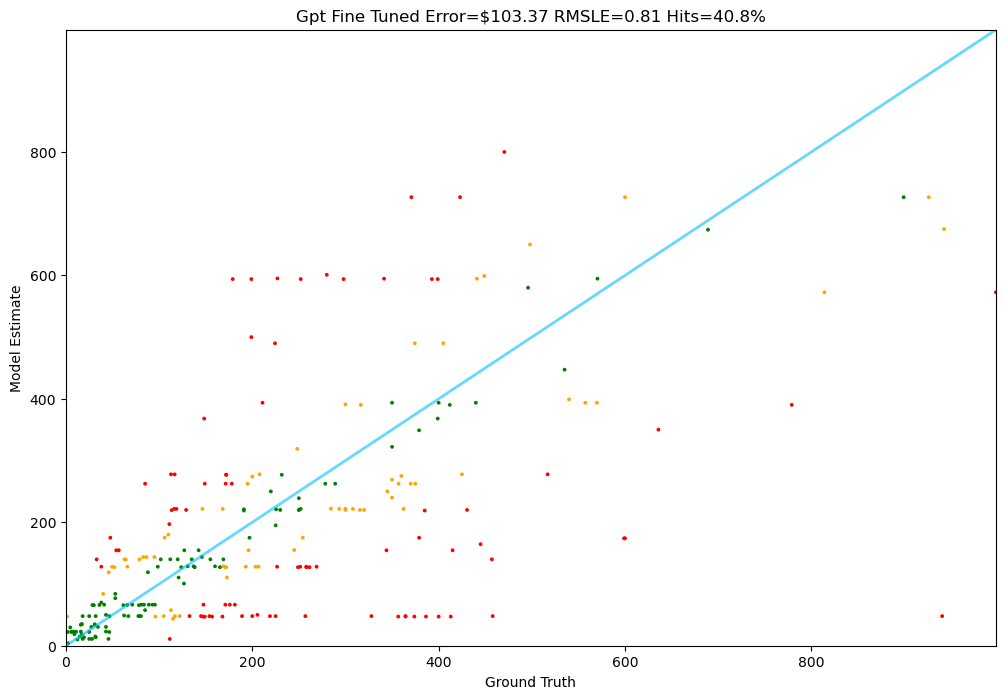

In [41]:
Tester.test(gpt_fine_tuned, test)